# Needed libraries

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
from matplotlib.collections import PatchCollection
import time
from datetime import datetime

# Algorithm

In [395]:
class multicastBeamForming:
    """ This class is the implementation of our proposed algorithm
    to the problem of multicast group forming 
    We define static BS characteristics as class attributes and
    keys parameters as the instance attributes (to be initialized 
    when instancing the class object)
    """
    C = 25             # Bitrate of multicast session [Mbps]               
    hU = 1.5           # Height of UEs [m]
    hA = 10            # Height of NR BS [m]
    hB = 1.70          # Height of blockers [m]
    rB = 0.4           # Radius of blockers [m]   
    lamB = 0.2         # Blockers density [bl./m^2]
    W = 50e6           # Available bandwidth [Hz]
    fc = 28            # Carrier frequency [GHz]
    wPRB = 1.44e6      # Size of PRB [Hz]
    G_rx = 5.57        # GA, GU Antenna/User array gains at NR BS and UE ends [dBi]
    N0 = -174          # Power spectral density of noise [dBm/Hz]
    MI = -100          # Margin interference [dBm]
    Rb = 32            # Number of available primary resource blocks [PRBs]
    M = 8              # Number of time slots in 1 ms subframe
    Sth = -9.478       # SINR threshold [dB]
    Pmax = 33          # Total available power [dBm]
        
    def __init__(self,params):
        self.K = params['K']                 # Number of multicast UEs
        self.L_beams = params['L_beams']     # Number of beams in the system
        self.R = params['R']                 # Service (cell) area radius [m]
        self.theta = params['theta']         # Max Beam angle
        
        self.radii_UEs = None
        self.angles_UEs = None
        self.groups = None
        self.powerSet = None
    
    """
    ###########################################
    
    USEFUL FUNCTIONS FOR ANALYTICAL COMPUTATIONS
    
    ############################################    
    """
    
    # Parameters conversion
    def convert_to_linear(self):
        """
        This functon converts these values to linear scale:
        GU(dBi)    ---> linear
        N0(dBm/hz) ---> linear
        MI(dB)     ---> linear
        Sth(dB)    ---> linear
        """
        G_rx_lin = 10.**(self.G_rx/10)
        noise = self.W * 10.**(self.N0/10.)
        MI_lin = 0*10**(self.MI/10)
        sth_lin = 10.**(self.Sth/10)
        
        return G_rx_lin, noise, MI_lin, sth_lin
    
    # Probability of blockage at distance y
    def pB(self, y):                
        rad = np.sqrt(np.power(y,2)-(self.hA-self.hU)**2)
        exponent = -2.0*self.lamB*self.rB*(rad*(self.hB-self.hU)/(self.hA-self.hU) + self.rB)
        return 1 - np.exp(exponent)
        
    
    # Compute the transmitted power for a group
    def Pt_dBm(self, dj, G_tx_lin):
        G_rx_lin, noise, MI_lin, S_th_lin = self.convert_to_linear()
        Pmax_watt = 10**(self.Pmax/10)/1000
        
        # Propagation coefficients 
        # For non-blocked and blocked conditions, 
        A1 = 10**(2*np.log10(self.fc)+3.24)
        A2 = 10**(2*np.log10(self.fc)+4.74)
        zeta = 2.1
        
        pBd = self.pB(dj)
        
        num = S_th_lin*(noise + MI_lin)
        den = G_rx_lin * G_tx_lin * np.power(dj,-1.*zeta) * ((1-pBd)/A1 + pBd/A2)
        P_tx_watt = num / den
        
        return P_tx_watt
    
    # Compute the SNR
    def calcSNR(self,dj,G_tx_lin):
        """
        dy        - Расстояние от БС до пользователя     [m]
        G_rx_lin  - Гейн группы в линейной скале         [linear scale]
        G_lin     - Гейн БС в линейной скале             [linear scale]
        """               
        Pmax_watt = 10**(self.Pmax/10)/1000
        A1 = 10**(2*np.log10(self.fc)+3.24)
        A2 = 10**(2*np.log10(self.fc)+4.74)
        zeta = 2.1
        pBd = self.pB(dj)
        
        G_rx_lin, noise, MI_lin, _ = self.convert_to_linear() # NOise = N0_lin * W
        
        num = Pmax_watt * G_tx_lin * G_rx_lin * np.power(dj,-zeta) * ((1-pBd)/A1 + pBd/A2)
        den = (noise + MI_lin)
        
        SNR_lin = num / den
        snr = 10. * np.log10(SNR_lin)
        
        return snr
    
    def spectralEfficiency(self,snr):
        """
        FIND THE  SPECTRAL EFFICIENCY BY MAPPING
        """
        sinr_grid = [-9.478,-6.658,-4.098,-1.798,0.399,
                     2.424,4.489,6.367,8.456,10.266,12.218,
                     14.122,15.849,17.786,19.809]
        
        spec_eff_grid = [0.15237,0.2344,0.377,0.6016,0.877,
                         1.1758,1.4766,1.9141,2.4063,2.7305,
                         3.3223,3.9023,4.5234,5.1152,5.5547]
        
        for idx,thres in enumerate(sinr_grid):
            if snr <= thres :
                return spec_eff_grid[idx]
        return spec_eff_grid[-1]
    
    
    def aj(self,sj):
        """
        # Cost aj is represented in terms of the number of PRBs
        # For assigned beam for group j
        # where sj is a spectral efficiency in bit/s/Hz 
        # of the worst UE in the group j
        """
        return (np.ceil(self.C / (sj * self.wPRB))).astype(int)
      
    """
    ###########################################
    
    METHODS FOR PROPOSED ALGORITHM
    
    ############################################    
    """
    
    def partition(self, collection):
        """
        # This makes all the possible partitions
        """
        if len(collection) == 1:
            yield [ collection ]
            return

        first = collection[0]
        for smaller in self.partition(collection[1:]):
            # insert `first` in each of the subpartition's subsets
            for n, subset in enumerate(smaller):
                yield smaller[:n] + [[ first ] + subset]  + smaller[n+1:]
            # put `first` in its own subset 
            yield [ [ first ] ] + smaller   
    
    def powerset(self, s):
        """
        We are given the array s
        The function
        """
        x = len(s)
        masks = [1 << i for i in range(x)]
        for i in range(1,1 << x):
            yield [ss for mask, ss in zip(masks, s) if i & mask]
    
    def generate_UEs(self,seed = None):
        """
        GENERATE UEs IN A SECTOR OF MAX_ANGLE
        """
        if seed is not None:
            np.random.seed(seed)
        self.radii_UEs = self.R * np.sqrt(np.random.rand(self.K))
        
        if seed is not None:
            np.random.seed(seed+2376)
        self.angles_UEs = np.random.rand(self.K) * self.theta
        
        # self.groups = list(self.partition(list(range(1,self.K+1))))
        # self.powerSet = list(self.powerset(list(range(1,self.K+1))))
        
    
    def plot_UEs(self,figsize=(8,8)):
        fig = plt.figure(figsize = figsize)
        ax = fig.add_subplot(projection='polar')
        UEs = list(range(1, self.K+1))
        
        n_theta = int(2*np.pi / self.theta)
        # print("n_theta: ", n_theta)
        ax.set_thetagrids([self.theta * i * 180 / np.pi for i in range(n_theta)])
        ax.set_rgrids([int(self.R/5),int(3*self.R/5),self.R],angle=180)

        ax.scatter(self.angles_UEs, self.radii_UEs,s=15)
        ax.scatter([0],[0],s=100.,color='black')
        ax.plot(np.linspace(0,2*np.pi,100),[self.R]*100,color='orange')
        
        for i, num in enumerate(UEs):
            ax.annotate(str(num),(self.angles_UEs[i],self.radii_UEs[i]+3.5),fontsize=10)
        
        timestp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        plt.savefig("Ues_"+timestp+".png",dpi=300)
        plt.show()
    
    
    def dist_BS_UEs(self):
        """
        THIS IS FOR NUMERICAL ANALYSIS
        WE COMPUTE THE DISTANCE BS-UE,
        KNOWING THE RADIUS BS-UE AND THE HEIGHT OF THE UE
        """
        return np.sqrt(self.radii_UEs**2 + (self.hA-self.hU)**2)
    
    # USED IN NEXT FUNCTION
    def find_multicasting_group_angle(self, group):
        gr_angles = self.angles_UEs[np.array(group)-1]
        return 0 if len(gr_angles)==1 else max(gr_angles) - min(gr_angles)
    
    
    def find_beam_angles(self):
        beam_angles = np.zeros(len(self.powerSet))
        for i, group in enumerate(self.powerSet):
            beam_angles[i] = self.find_multicasting_group_angle(group)
        return beam_angles * 180 / np.pi
    
    # USED IN NEXT FUNCTION
    def single_group_gain(self, alpha):
        angles = [0.79,1.59,3.18,6.37,12.75,25.5,51,102]
        # gain_lin = [115.02,57.51,28.76,14.38,7.20,3.61,1.84,1.]
        gain_dBi2lin = 10**(np.array([20.6075,17.59,14.58,11.57,8.57,5.57,2.643,2.58])/10.)
        dE = [686.,494.,355.,255.,183.,132.,107.,95.]
        
        for idx, thres in enumerate(angles):
            if alpha <= thres:
                return np.array([angles[idx], gain_dBi2lin[idx], dE[idx]])
        return np.array([angles[-1], gain_dBi2lin[-1], dE[-1]])
    
    def find_trans_Gain(self):
        beam_angles = self.find_beam_angles()
        G_tx_lin = [0] * len(self.powerSet)
        for i in range(len(self.powerSet)):
            G_tx_lin[i] = self.single_group_gain(beam_angles[i])
        return np.array(G_tx_lin)
    
    
    def max_dist_group(self):
        dist_BS_UE = self.dist_BS_UEs()
        max_dist = np.array([max(dist_BS_UE[np.array(group)-1])
                             for group in self.powerSet])
        return max_dist
    
    
    def worst_UE_group(self):
        dist_BS_UE = self.dist_BS_UEs()
        worst_elt = np.array([group[np.argmax(dist_BS_UE[np.array(group)-1])]
                              for group in self.powerSet])
        return worst_elt
    
    def elligible_groups(self):
        """For every subset, we find the farthest UE, 
        the beam angle needed to serve the group, and
        we check if it's possible to serve the group with 
        such a beam if not we exclude it from the powerSet
        """
        dE = self.find_trans_Gain()[:,2]
        # Farthest UE in a group
        farthest = self.max_dist_group()
        
        not_included = farthest > dE
        
        deleted = 0
        num_subsets = len(self.powerSet)        
        for idx in range(num_subsets):
            if not_included[idx]:
                del self.powerSet[idx-deleted]
                deleted += 1
        
        deleted = 0
        num_partition = len(self.groups)
        for idx in range(num_partition):
            if any((True for elt in self.groups[idx-deleted] if elt not in self.powerSet)):
                del self.groups[idx-deleted]
                deleted += 1
    
    """The next functions help to check to state 
    of every UE and of every partition
    """
    def info_UEs(self):
        data = {}
        data['UE'] = list(range(1,self.K+1))
        data['Angle'] = self.angles_UEs * 180 / np.pi
        data['Radius'] = self.radii_UEs
        data['DIST TO BS'] = self.dist_BS_UEs()
        
        return pd.DataFrame(data).set_index('UE')
        
    def info_subsets(self):
        # Transmitted gain
        UEs_angles = self.find_beam_angles()
        gains_info = self.find_trans_Gain()
        
        # Farest UE in a group
        farestDist = self.max_dist_group()
        # Worst element
        welt = self.worst_UE_group()
        
        # Transmitted Power
        P_tx_watt = self.Pt_dBm(farestDist, gains_info[:,1])
        P_tx_dBm = 10*np.log10(1000*P_tx_watt)
               
        # Signal Noise Ratio
        snr = self.calcSNR(farestDist,gains_info[:,1])
        # Spectral Efficiency
        se = np.array([self.spectralEfficiency(snr_j) for snr_j in snr])
        
        data = {}
        data['Subsets'] = self.powerSet
        data['Worst Elt'] = welt
        
        data['dj'] = farestDist
        data['UEs Angle'] = UEs_angles
        data['HPBW'] = gains_info[:,0]
        data['G_Tx_lin'] = gains_info[:,1]
        data['dE'] = gains_info[:,2]
        
        data['Feasible'] = farestDist <= gains_info[:,2]
        
        data['P_tx(dBm)'] = P_tx_dBm
        data['P_tx(watt)'] = P_tx_watt
        
        data['SINR(dB)'] = snr
        data['Spec.Eff'] = se
        
        df = pd.DataFrame(data)
        
        return df.set_index('Subsets')
   
    """
    This is the realization of the algorithm
    """    
    def indicator_matrix(self):       
        """
        G[i,j] = 1 if the subset number j enters into the i-th partition, else G[i,j] = 0
        """
        G = [0]*len(self.groups)

        for i,grp in enumerate(self.groups):
            indicator = np.zeros(len(self.powerSet),dtype=int)
            for elt in grp:
                indicator += np.array([item == elt for item in self.powerSet]).astype(int)
            G[i] = indicator
        return np.array(G)
        
    def BinPackProblem_algorithm(self):             
        start_time = time.process_time()
        
        # Matrix indicator
        G = self.indicator_matrix()
        # print(f'G shape {G.shape}')     
        
        # Transmitted gain
        G_tx_lin = self.find_trans_Gain()[:,1]
        # print(f'Gain len {len(G_tx_lin)}')
        # Farthest UE in a group
        dj = self.max_dist_group()
        # print(f'Farthest dist {len(dj)}')
        
        
        # Transmitted Power
        PA_watt = 10**(self.Pmax/10)/1000
        
        P_tx_watt = self.Pt_dBm(dj, G_tx_lin)
        # print(f'P_tx_watt {len(P_tx_watt)}')
        # Vector power
        Pow_tx = P_tx_watt.reshape((-1,1))
        # print(f'Pow_tx shape {Pow_tx.shape}')
        
        
        # Compute the Signal Noise Ratio for every group
        snr = self.calcSNR(dj,G_tx_lin)
        # print(f'SINR {len(snr)}')
        # Spectral Efficiency
        se = np.array([self.spectralEfficiency(snr_j) for snr_j in snr])
        # print(f'Spec eff {len(se)}')
             
            
        # Number of physical ressource blocks
        AphRB = self.aj(se).reshape((-1,1))
        # print("A_PRB.shape: ",AphRB.shape)
        # Нужное количество ресурсных блоков для обсл. разбиения № i
        A_partition = np.dot(G,AphRB).flatten()
        # print("A_partition.shape: ",A_partition.shape)
                
        
        # Формула №13 из статьи 
        # Нужное количество тайм слотов блоков для обсл. разбиения № i
        time_Gi = np.ceil(A_partition/self.Rb).astype(int)
        # print(f'Number of time slots: {time_Gi}')
        # Условие №9 из статьи
        G = G[time_Gi <= self.M]
        
        
        # Условие №8 из статьи
        # np.dot(G,ones).flatten() <= L_beams
        ones = np.ones((len(self.powerSet),1),dtype=int)
        G = G[np.dot(G,ones).flatten() <= self.L_beams]
        
        
        # Условие №10 из статьи
        # The power sum must be less than Pmax
        G = G[np.dot(G,Pow_tx).flatten() <= PA_watt]
        
        
        # Условие №14 из статьи
        Aj_included = AphRB.flatten() <= self.M * self.Rb
        # Проверка выполнения условия №14 из статьи
        condition14 = np.array([np.all(np.logical_or(~group.astype(bool),Aj_included)) for group in G])
        # print(f"Cond 14: {condition14}")
        G = G[condition14]
        
        
        # Условие №15 из статьи
        # np.dot(G,Aj).flatten() <= M * L_beams * Rb
        G = G[np.dot(G,AphRB).flatten() <= self.M * self.L_beams * self.Rb]
        
        
        # Лучшее разбиение
        Ai_final = np.dot(G,AphRB).flatten()
        index = np.argmin(Ai_final)
        
        # Subsets of the best partition
        idx = np.where(G[index].astype(bool))[0]
        
        # print("Best partition: ", end='')
        ans = []
        for ind in idx:
            ans.append(self.powerSet[ind])
        # print(ans)
        end_time = time.process_time()
        
        ans.sort(key = lambda group:min(self.angles_UEs[np.array(group)-1]))
        
#         print(f'Number of PRBs/partition: {Ai_final}')
        
#         print("Optimal number of beams: ",len(ans))
#         print(f'Ratio of used ressources: {Ai_final[index]/(self.M * self.L_beams * self.Rb)}')
#         print(f'Execution time: {1000*(end_time - start_time)}ms')
        
        return ans, len(ans), end_time - start_time
    
    def plot_Answer(self,Ans,figsize=(8,8),title=None):
        fig = plt.figure(figsize = figsize)
        ax = fig.add_subplot(projection='polar')
        UEs = list(range(1, self.K+1))
        alpha = np.array([0.79,1.59,3.18,6.37,12.75,25.5,51,102])
        color = '#FF1493 #FF00FF #FF0000 #FFD700 #00FF00 #00FFFF #00BFFF #7FFFD4'.split()
    
        n_theta = int(2*np.pi / self.theta)
        ax.set_thetagrids([self.theta * i * 180 / np.pi for i in range(n_theta)])
        ax.set_rgrids([50,150,250],angle=180)
        ax.scatter([0],[0],s=100.,color='black')
        ax.plot(np.linspace(0,2*np.pi,100),[self.R]*100,color='orange')
        
        for group in Ans:                    
            group_angle = self.find_multicasting_group_angle(group)* 180 / np.pi
            cover = alpha[alpha>=group_angle]
            beam_angle = cover[0] if len(cover)>0 else 102.
            clrId = np.where(alpha==beam_angle)[0][0]
                       
            idx = np.array(group) - 1
            ax.scatter(self.angles_UEs[idx], self.radii_UEs[idx],s=5, color=color[clrId])
            
            rad = max(self.radii_UEs[idx])+ 4
            theta_mid = (max(self.angles_UEs[idx]) + min(self.angles_UEs[idx]))/2
            theta_width = np.deg2rad(beam_angle+2)
            
            ax.bar(x=theta_mid, height = rad, width=theta_width,\
                   bottom=0, color=color[clrId], alpha=0.15)
         
        for i, num in enumerate(UEs):
            ax.annotate(str(num),(self.angles_UEs[i],self.radii_UEs[i]+3.5),fontsize=12)
        
        timestp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        if title is not None:
            ax.set_title(title)
        plt.savefig("Ans"+timestp+title+".png",dpi=300)
        plt.show()

# ML models

In [210]:
def get_group(UE, partition):
    index=0
    for group in partition:
        if UE in group:
            return group, index
        else:
            index += 1
    return
    
def save_dataset(N):
    import csv

    filterfile = open('newfilterdata.csv','a')
    csvfilter = csv.writer(filterfile)
    csvfilter.writerow(['K','filter_time','algorithm_time'])

    dataset = open('newdataset.csv','a')
    csvdataset = csv.writer(dataset)
    csvdataset.writerow(['UE','K','phi','radius','PTx','SINR','Lopt','group','target'])              

    params = {
        'K':0,
        'L_beams':5,
        'R':250,
        'theta': 2*np.pi/3
    }

    for k in range(2,11):
        for _ in range(N):
            params['K'] = k
            task = multicastBeamForming(params)
            task.generate_UEs()

            filter_start = time.process_time()
            task.elligible_groups()
            filter_end = time.process_time()

            res, beams, time_secs = task.BinPackProblem_algorithm()
            csvfilter.writerow([params['K'], filter_end-filter_start, time_secs])

            dist = task.dist_BS_UEs()                
            PTxs = task.Pt_dBm(dist, 115.02)
            SINR = task.calcSNR(dist, 115.02)

            for UE in range(1,params['K']+1):
                group, idx = get_group(UE,res)
                csvdataset.writerow([UE, params['K'], task.angles_UEs[UE-1],\
                                     task.radii_UEs[UE-1], PTxs[UE-1],\
                                     SINR[UE-1], beams, group, idx])
    filterfile.close()
    dataset.close()

In [100]:
# save_dataset(1000)

In [274]:
df = pd.read_csv('newdataset.csv')

In [275]:
df

,UE,K,phi,radius,PTx,SINR,Lopt,group,target
0,1,2,1.434124,178.426629,0.007974,14.505450,2,[1],1
1,2,2,0.147380,199.994310,0.010926,13.137585,2,[2],0
2,1,2,1.449989,133.641614,0.003715,17.822278,1,"[1, 2]",0
3,2,2,1.666149,137.998790,0.004035,17.463485,1,"[1, 2]",0
4,1,2,0.312564,160.714596,0.006017,15.728219,2,[1],0
...,...,...,...,...,...,...,...,...,...
53995,6,10,2.091340,199.688971,0.010879,13.156143,8,[6],7
53996,7,10,1.549955,157.671297,0.005719,15.948871,8,[7],5
53997,8,10,0.669472,182.489631,0.008479,14.238395,8,[8],1
53998,9,10,1.828364,87.572146,0.001304,22.368436,8,[9],6


In [276]:
intcols = ['UE','K','Lopt','target']
floatcols = ['phi', 'radius', 'PTx', 'SINR']

df[intcols] = df[intcols].astype(int)
df[floatcols] = df[floatcols].astype(float)

In [277]:
df.dtypes

UE          int64
K           int64
phi       float64
radius    float64
PTx       float64
SINR      float64
Lopt        int64
group      object
target      int64
dtype: object

In [299]:
data = df[df['Lopt'] < 6]

In [183]:
Lopts = data['Lopt'].unique()
Klist = data['K'].unique()
L_mean = [data[data['K']==k]['Lopt'].mean() for k in Klist]

In [185]:
# L_mean = [1] + L_mean

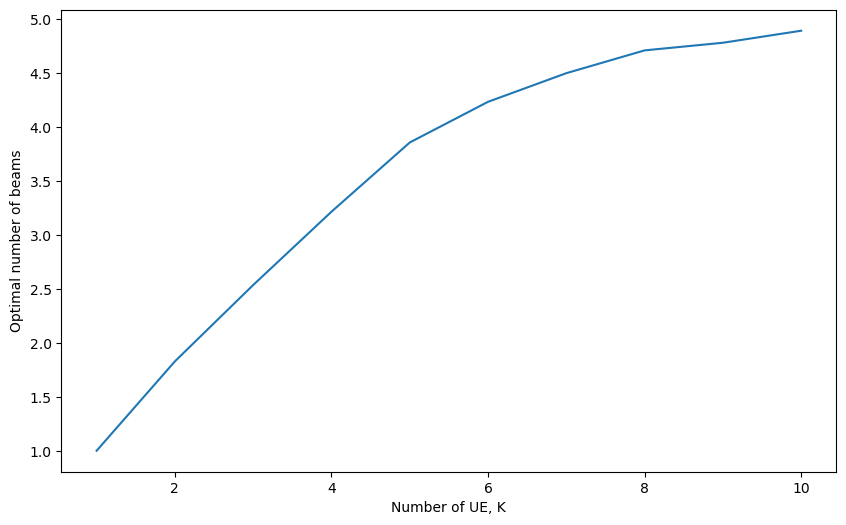

In [186]:
plt.figure(figsize=(10,6))
plt.plot(range(1,11),L_mean)
plt.xlabel('Number of UE, K')
plt.ylabel('Optimal number of beams')
plt.savefig("newL_Optimal_beams.png")
plt.show()

In [279]:
data.describe()

,UE,K,phi,radius,PTx,SINR,Lopt,target
count,35903.000000,35903.000000,35903.000000,35903.000000,35903.000000,35903.000000,35903.000000,35903.000000
mean,3.578392,6.156784,1.047563,163.603736,0.008329,16.421166,3.998106,1.484862
std,2.167690,2.206781,0.602291,59.821100,0.006093,5.488421,1.042865,1.262865
min,1.000000,2.000000,0.000115,0.970786,0.000007,10.349121,1.000000,0.000000
25%,2.000000,4.000000,0.522629,120.998006,0.002885,12.287985,3.000000,0.000000
50%,3.000000,6.000000,1.049695,172.465160,0.007271,14.905963,4.000000,1.000000
75%,5.000000,8.000000,1.568450,214.355116,0.013286,18.920390,5.000000,2.000000
max,10.000000,10.000000,2.094376,249.998991,0.020763,44.983760,5.000000,4.000000


In [280]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

In [301]:
data[['SINR']] = StandardScaler().fit_transform(data[['SINR']])

/tmp/ipykernel_86162/2592561313.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[['SINR']] = StandardScaler().fit_transform(data[['SINR']])


In [302]:
tmp = data[['radius','PTx','Lopt']]

In [303]:
data[['radius','PTx','Lopt']] = (tmp - tmp.min())/(tmp.max()-tmp.min())

/tmp/ipykernel_86162/655048291.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[['radius','PTx','Lopt']] = (tmp - tmp.min())/(tmp.max()-tmp.min())


In [304]:
data[['K']] = data[['K']]/60
data

/tmp/ipykernel_86162/400221023.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[['K']] = data[['K']]/60


,UE,K,phi,radius,PTx,SINR,Lopt,group,target
0,1,0.033333,1.434124,0.712593,0.383820,-0.349052,0.25,[1],1
1,2,0.033333,0.147380,0.799201,0.526040,-0.598283,0.25,[2],0
2,1,0.033333,1.449989,0.532754,0.178648,0.255289,0.00,"[1, 2]",0
3,2,0.033333,1.666149,0.550251,0.194063,0.189915,0.00,"[1, 2]",0
4,1,0.033333,0.312564,0.641469,0.289550,-0.126258,0.25,[1],0
...,...,...,...,...,...,...,...,...,...
53965,6,0.166667,1.406370,0.742461,0.429249,-0.437495,1.00,"[1, 6]",3
53966,7,0.166667,0.888481,0.859304,0.644949,-0.759449,1.00,"[7, 10]",2
53967,8,0.166667,0.615346,0.492565,0.146435,0.412295,1.00,[8],1
53968,9,0.166667,0.150390,0.591534,0.234012,0.042033,1.00,"[3, 5, 9]",0


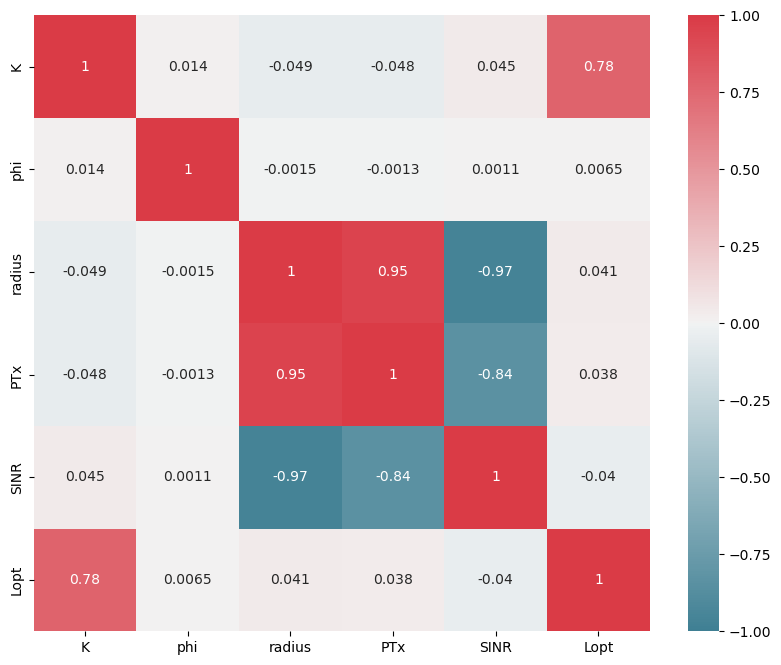

In [305]:
corr = data[['K', 'phi', 'radius', 'PTx', 'SINR', 'Lopt']].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr,
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            vmin=-1.0, vmax=1.0,
            square=True, ax=ax,
            annot=True
           )
# plt.savefig('correlation.png')
plt.show()

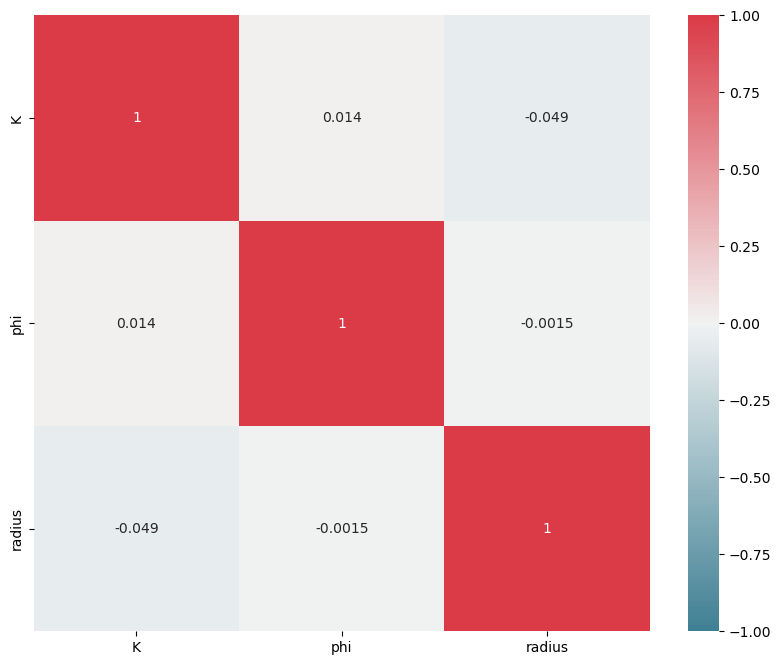

In [306]:
corr1 = data[['K', 'phi', 'radius']].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr1,
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            vmin=-1.0, vmax=1.0,
            square=True, ax=ax,
            annot=True
           )
# plt.savefig('correlation_01.png')
plt.show()

In [307]:
data5 = data[data['Lopt']==1.0]
data5

,UE,K,phi,radius,PTx,SINR,Lopt,group,target
9045,1,0.083333,1.678066,0.487881,0.142958,0.431266,1.0,[1],3
9046,2,0.083333,2.026133,0.614337,0.258351,-0.036157,1.0,[2],4
9047,3,0.083333,0.015143,0.659201,0.311313,-0.183539,1.0,[3],0
9048,4,0.083333,1.299054,0.543844,0.188317,0.213657,1.0,[4],2
9049,5,0.083333,1.064259,0.441417,0.111411,0.628018,1.0,[5],1
...,...,...,...,...,...,...,...,...,...
53965,6,0.166667,1.406370,0.742461,0.429249,-0.437495,1.0,"[1, 6]",3
53966,7,0.166667,0.888481,0.859304,0.644949,-0.759449,1.0,"[7, 10]",2
53967,8,0.166667,0.615346,0.492565,0.146435,0.412295,1.0,[8],1
53968,9,0.166667,0.150390,0.591534,0.234012,0.042033,1.0,"[3, 5, 9]",0


In [308]:
X,y = data5[['K', 'phi', 'radius']].values, data5['target'].values

In [309]:
X_train, X_test, y_train, y_test = train_test_split(
...     X, y, test_size=0.3, random_state=42)

In [310]:
uniques, counts = np.unique(y,return_counts=True)

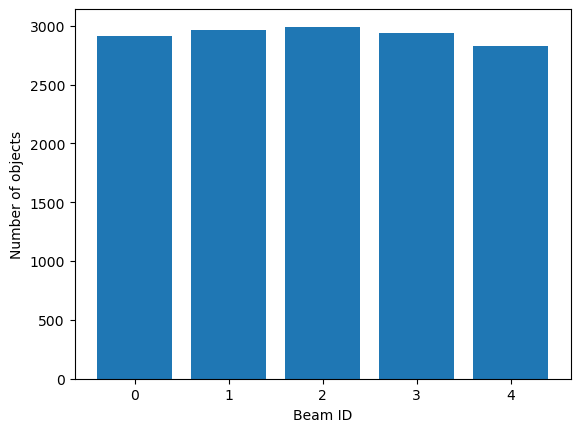

In [311]:
plt.bar(uniques, counts)
plt.xlabel("Beam ID")
plt.ylabel("Number of objects")

plt.savefig('bars.png', dpi=300)
plt.show()

In [312]:
from sklearn.metrics import confusion_matrix

In [313]:
X_train

array([[0.15      , 1.88458075, 0.82635343],
       [0.13333333, 0.41360943, 0.78712386],
       [0.08333333, 0.55021714, 0.71015132],
       ...,
       [0.11666667, 1.06455763, 0.67117132],
       [0.08333333, 0.02719662, 0.45680502],
       [0.13333333, 1.58651634, 0.19152844]])

## Decision Trees

In [316]:
from sklearn import tree
dt = tree.DecisionTreeClassifier()

In [317]:
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [318]:
sum(dt.predict(X_test) == y_test)/len(y_test)

0.49305713635328935

In [320]:
dt.score(X_train, y_train)

1.0

## Logistic Regression

In [314]:
from sklearn.linear_model import LogisticRegression as logreg

In [322]:
lrg = logreg(random_state=0).fit(X_train, y_train)

/opt/anaconda3/envs/studhub/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [323]:
sum(lrg.predict(X_test)==y_test)/len(y_test)

0.5816071022080582

In [325]:
lrg.score(X_train, y_train)

0.5903990633232511

## Naive Bayes

In [326]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

In [327]:
y_pred = gnb.fit(X_train, y_train).predict(X_test)

In [328]:
sum(y_pred==y_test)/len(y_test)

0.5725017072615525

## Support Vector Machine

In [329]:
from sklearn.svm import SVC

In [330]:
svm = SVC(gamma='auto')

In [331]:
y_pred = svm.fit(X_train, y_train).predict(X_test)

In [332]:
sum(y_pred==y_test)/len(y_test)

0.5870703391759617

In [311]:
confusion_matrix(y_test, y_pred)

array([[621, 193,  45,  12,  11],
       [172, 466, 253,  45,   8],
       [ 10, 175, 411, 271,  16],
       [  0,  22, 163, 475, 193],
       [  0,   0,  16, 210, 605]])

## K-Nearest Neighbors (KNN)

In [333]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)

In [334]:
neigh.fit(X_train, y_train)

KNeighborsClassifier()

In [335]:
y_pred = neigh.predict(X_test)

In [336]:
sum(y_pred==y_test)/len(y_test)

0.5399499203277942

# ML Solution

In [406]:
params = {
        'K':60,
        'L_beams':5,
        'R':250,
        'theta': 2*np.pi/3
    }
    
test = multicastBeamForming(params)
test.generate_UEs(seed=65748)
# test.elligible_groups()
# res, _, _ = test.BinPackProblem_algorithm()

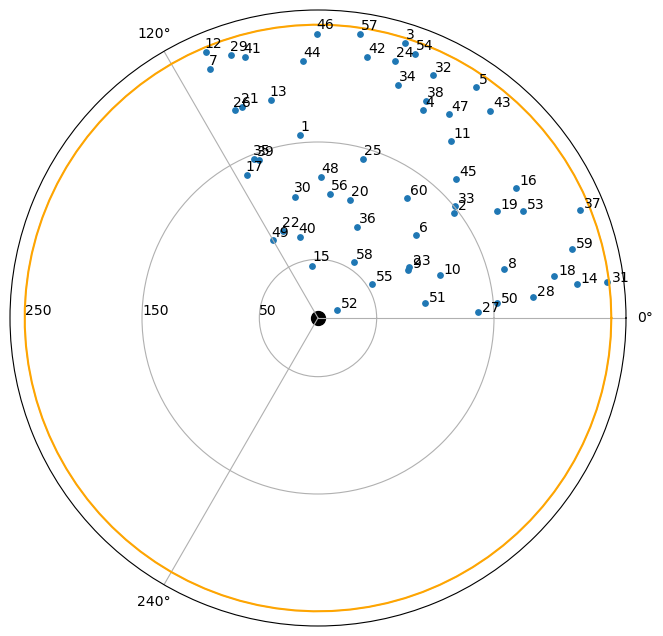

In [407]:
test.plot_UEs()

In [382]:
res

[[1, 5], [4], [2], [6, 7], [3]]

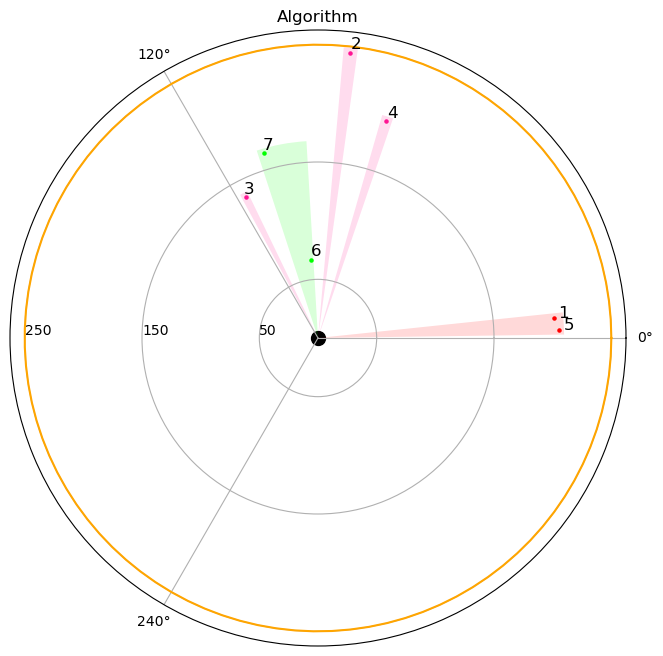

In [384]:
test.plot_Answer(res,title='Algorithm')

In [408]:
x1 = (np.array([test.K]*test.K)/60).reshape((-1,1))
x2 = (test.angles_UEs).reshape((-1,1))
x3 = (test.radii_UEs / 250).reshape((-1,1))


Xnew = np.hstack((x1,x2,x3))

In [409]:
Xnew

array([[1.        , 1.66632909, 0.62802328],
       [1.        , 0.65618224, 0.58669178],
       [1.        , 1.26597364, 0.98323157],
       [1.        , 1.10094539, 0.79427601],
       [1.        , 0.96974425, 0.95518075],
       [1.        , 0.70659544, 0.43804458],
       [1.        , 1.9787672 , 0.9238837 ],
       [1.        , 0.25811847, 0.65459562],
       [1.        , 0.49327103, 0.34893996],
       [1.        , 0.33743218, 0.43967712],
       [1.        , 0.9255037 , 0.75420457],
       [1.        , 1.97035129, 0.98505925],
       [1.        , 1.78539853, 0.76032566],
       [1.        , 0.13241759, 0.8897048 ],
       [1.        , 1.67557003, 0.17990992],
       [1.        , 0.58229086, 0.80748231],
       [1.        , 2.03229923, 0.54433738],
       [1.        , 0.17573235, 0.81793749],
       [1.        , 0.53660296, 0.71039073],
       [1.        , 1.30693416, 0.41577539],
       [1.        , 1.91539507, 0.76352019],
       [1.        , 1.95086155, 0.3194188 ],
       [1.

In [410]:
mlres = []
for model in [dt, lrg, gnb, svm, neigh]:
    mlres.append(model.predict(Xnew))

In [411]:
mlres

[array([3, 1, 4, 3, 2, 3, 4, 1, 0, 0, 3, 4, 4, 0, 4, 1, 4, 1, 1, 3, 4, 2,
        0, 3, 3, 4, 0, 0, 4, 4, 0, 2, 1, 3, 4, 2, 0, 3, 4, 3, 4, 4, 2, 3,
        0, 4, 1, 3, 0, 0, 0, 1, 0, 3, 0, 3, 3, 0, 0, 2]),
 array([4, 0, 3, 2, 2, 1, 4, 0, 0, 0, 2, 4, 4, 0, 4, 0, 4, 0, 0, 2, 4, 4,
        0, 3, 3, 4, 0, 0, 4, 4, 0, 2, 1, 2, 4, 2, 0, 2, 4, 4, 4, 3, 2, 4,
        2, 4, 2, 4, 4, 0, 0, 0, 0, 2, 0, 3, 3, 2, 0, 2]),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
 array([4, 1, 2, 2, 2, 1, 4, 0, 0, 0, 2, 4, 4, 0, 4, 1, 4, 0, 0, 2, 4, 4,
        0, 2, 2, 4, 0, 0, 4, 4, 0, 2, 1, 2, 4, 2, 0, 2, 4, 4, 4, 2, 2, 4,
        2, 4, 2, 4, 4, 0, 0, 0, 0, 2, 0, 4, 2, 2, 0, 2]),
 array([4, 2, 1, 3, 2, 1, 4, 0, 1, 0, 2, 4, 4, 0, 3, 1, 4, 0, 1, 3, 4, 2,
        1, 3, 3, 4, 0, 0, 3, 4, 0, 2, 2, 3, 4, 2, 0, 3, 4, 4, 4, 3, 2, 4,
        1, 3, 2, 3, 3, 0, 0,

In [412]:
# def mlAns(ypred):
#     classes = np.unique(ypred)[0]
#     ans = []
#     for class_ in classes:
#         ans.apprend([i+1 for i in range(len(ypred)) if ypred[i]==class_])

In [413]:
def mlAns(ypred):
    classes = np.unique(ypred)
    for class_ in classes:
        yield [i+1 for i in range(len(ypred)) if ypred[i]==class_]

In [414]:
titles = ['Decision trees', 'Logistic Regression', 'Naive Bayes',\
          'Support Vector machine', 'K Nearest Neighbors']

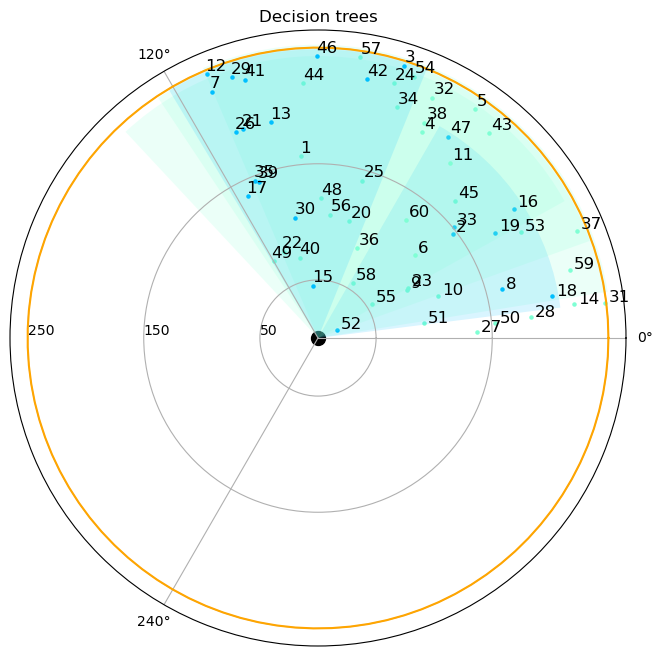

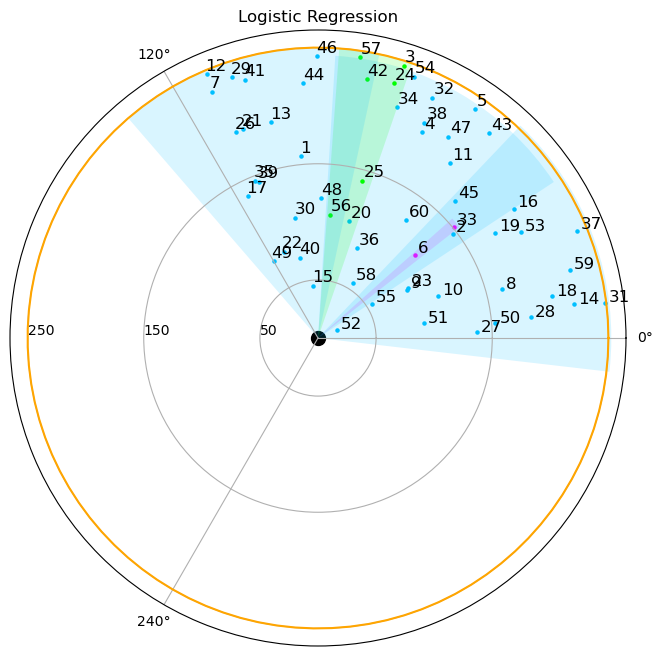

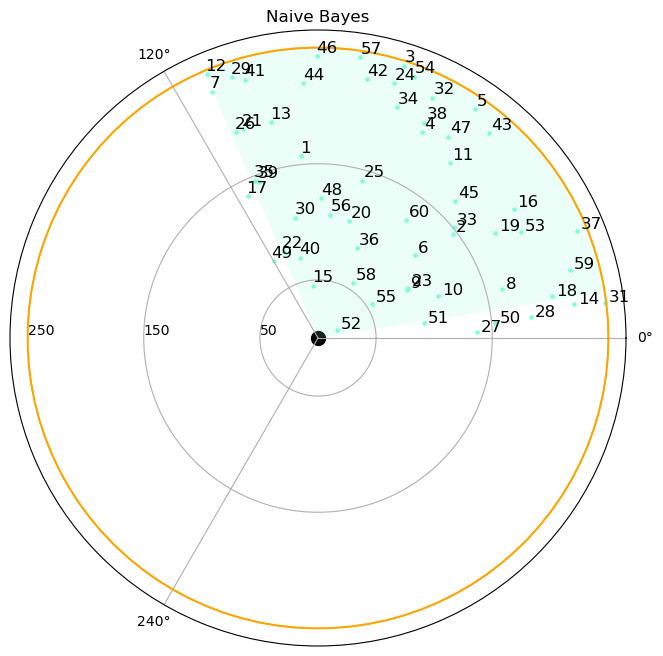

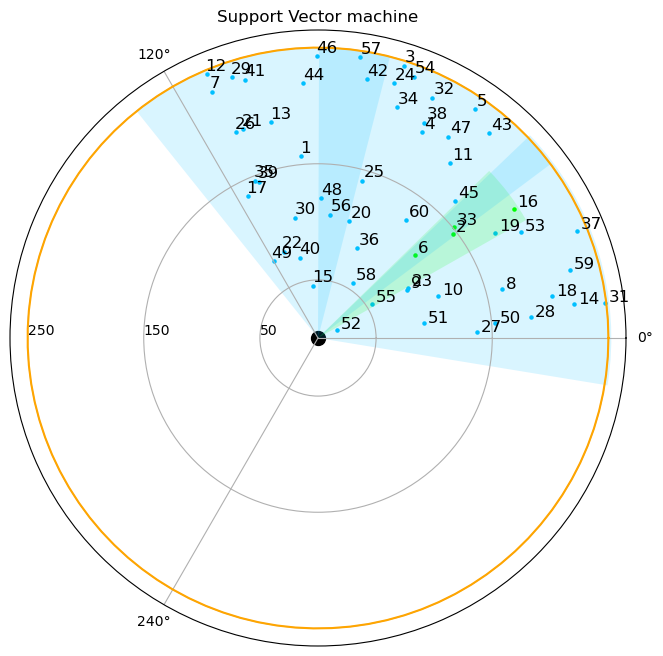

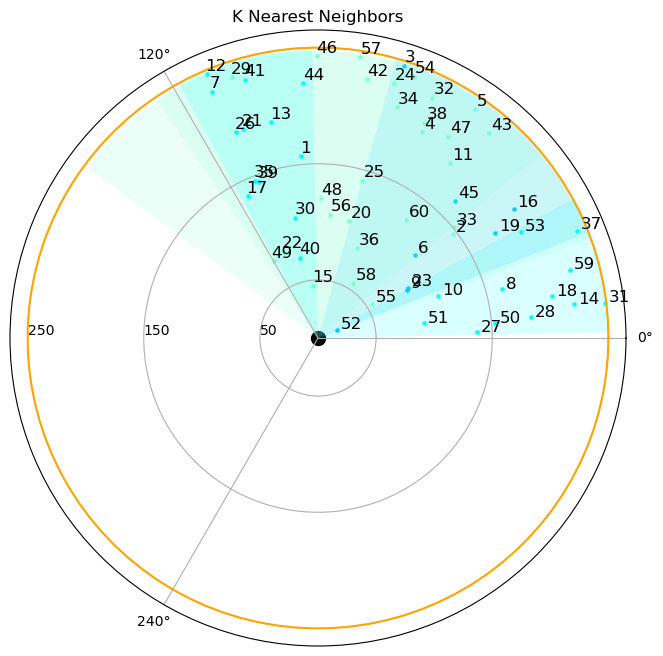

In [415]:
for ypred_, title_ in zip(mlres,titles):
    ans_ = list(mlAns(ypred_))
    test.plot_Answer(ans_,title=title_)

# Time analysis

In [3]:
dftime = pd.read_csv('filterdata.csv')

In [4]:
dftime.tail(10)

,K,filter_time,algorithm_time
1790,10,1.360068,0.000520
1791,10,1.375587,0.001675
1792,10,1.370938,0.001167
1793,10,1.369939,0.001035
1794,10,1.375767,0.002185
1795,10,1.370353,0.001101
1796,10,1.381933,0.002275
1797,10,1.375743,0.002720
1798,10,1.385470,0.003624
1799,10,1.376676,0.002178


In [5]:
tmp = pd.DataFrame({"K":[11],"filter_time":[68.499],"algorithm_time":[0.005328595]})
dftime = pd.concat([dftime,tmp], ignore_index = True)

In [6]:
K_list = dftime.K.unique()
filterT = 1000*np.array([dftime[dftime['K']==k]['filter_time'].mean() for k in K_list])
algorithmT = 1000*np.array([dftime[dftime['K']==k]['algorithm_time'].mean() for k in K_list])

In [272]:
algorithmT

array([0.35395352, 0.24041296, 0.23700123, 0.29332024, 0.37539065,
       0.51055786, 0.90175937, 1.33221968, 3.47392009, 5.328595  ])

In [7]:
new_time = filterT+algorithmT
old_time = np.array([0.008,0.01,0.06,10.03,54.35])*6e4

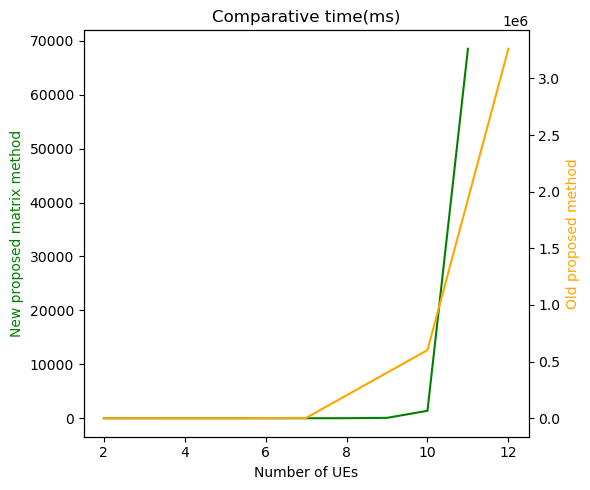

In [18]:
fig, ax = plt.subplots(figsize=(6,5))

# color = 'red'
# ax[0].set_xlabel('Number of UEs')
# ax[0].set_ylabel('Time (ms)')
# ax[0].plot(K_list[:-1], filterT[:-1], color=color)
# ax[0].set_ylim([0,200])
# ax[0].set_title('Filtering time growth')

# color = 'blue'
# ax[1].set_xlabel('Number of UEs')
# ax[1].set_ylabel('Time (ms)')
# ax[1].plot(K_list, algorithmT, color=color,)
# ax[1].set_title('Algorithm time growth')

color = 'green'
ax.set_xlabel('Number of UEs')
ax.set_ylabel('New proposed matrix method', color=color)
ax.plot(K_list, new_time, color=color)
ax.set_title('Comparative time(ms)')

color = 'orange'
ax3 = ax.twinx()
ax3.plot([2,5,7,10,12],old_time, color=color)
ax3.set_ylabel('Old proposed method', color=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.savefig('time analysis02.png',dpi=300)
plt.show()

# Initial parameters

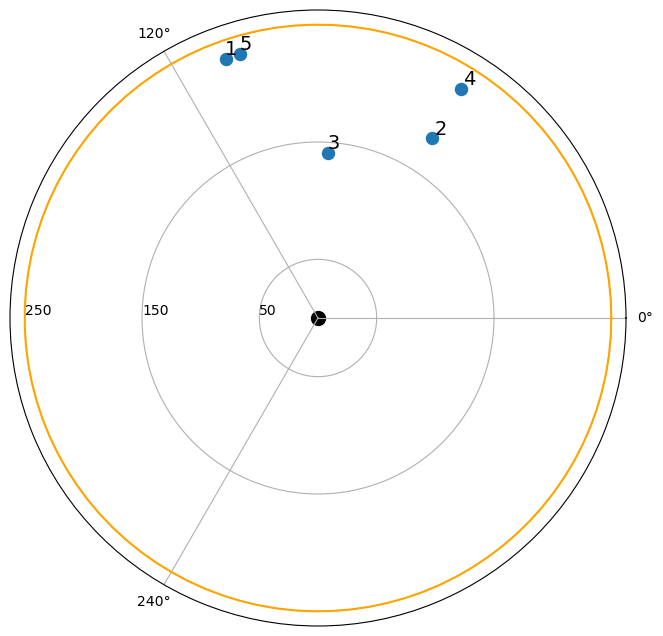

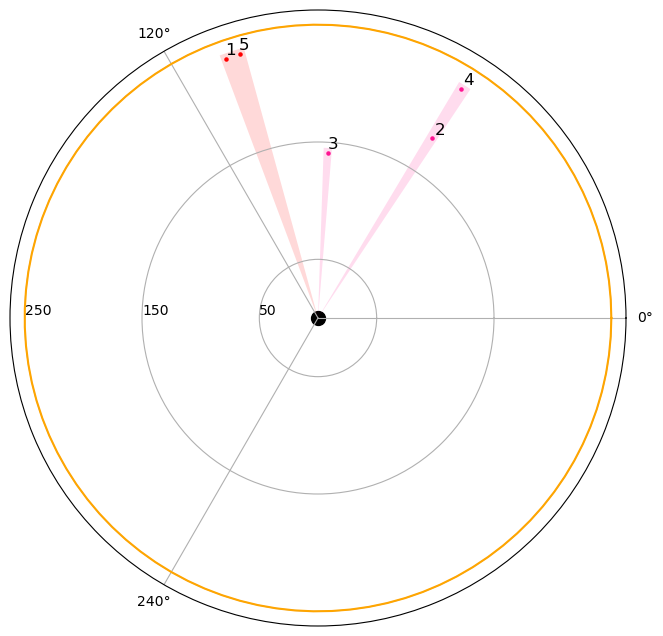

In [267]:
for _ in range(1):
    # K = np.random.randint(2,11)
    params = {
        'K':5,
        'L_beams':5,
        'R':250,
        'theta': 2*np.pi/3
    }
    
    test = multicastBeamForming(params)
    test.generate_UEs()
    test.elligible_groups()
    res, _, _ = test.BinPackProblem_algorithm()
    test.plot_UEs()
    test.plot_Answer(res)

In [270]:
_

0.002309085999996796

In [268]:
test.powerSet

[[1], [2], [3], [4], [2, 4], [5], [1, 5]]

In [269]:
test.groups

[[[3], [2, 4], [1, 5]],
 [[1], [3], [2, 4], [5]],
 [[2], [3], [4], [1, 5]],
 [[1], [2], [3], [4], [5]]]

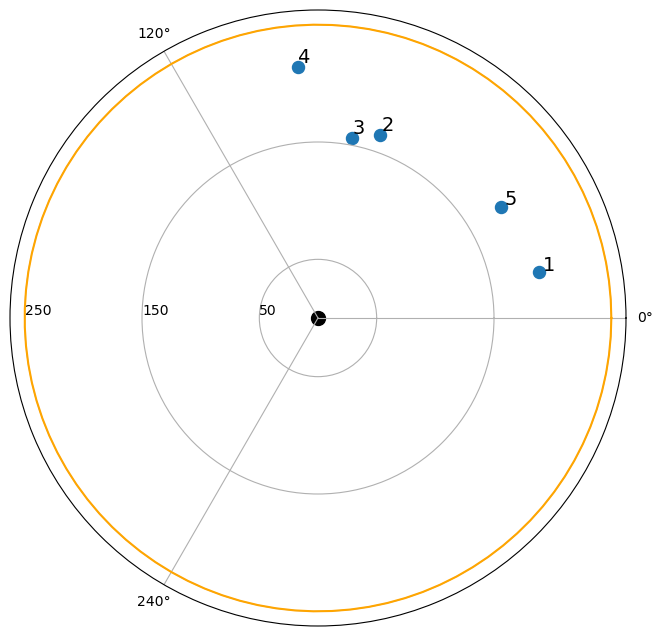

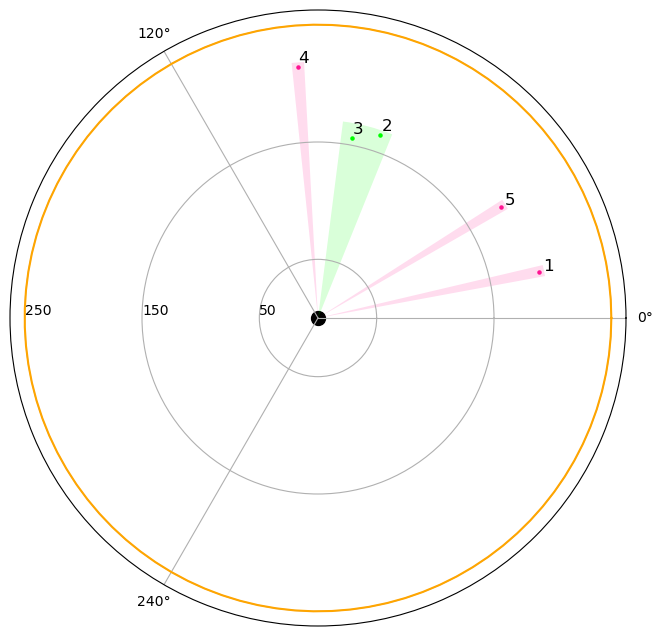

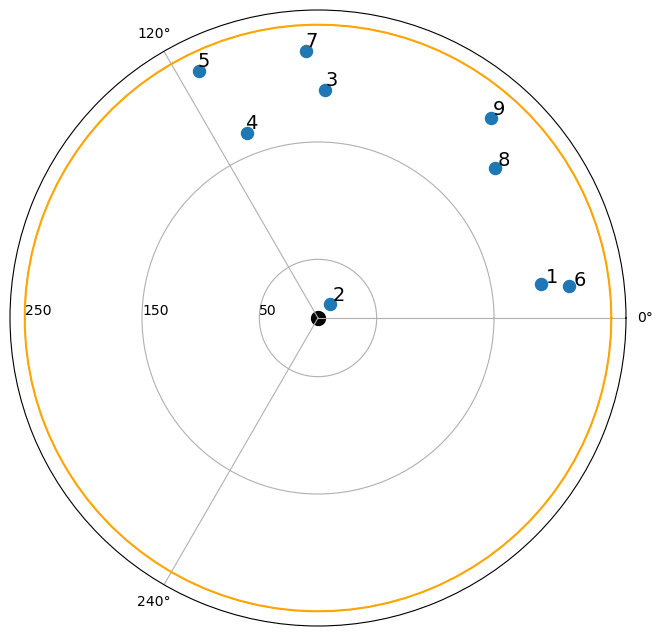

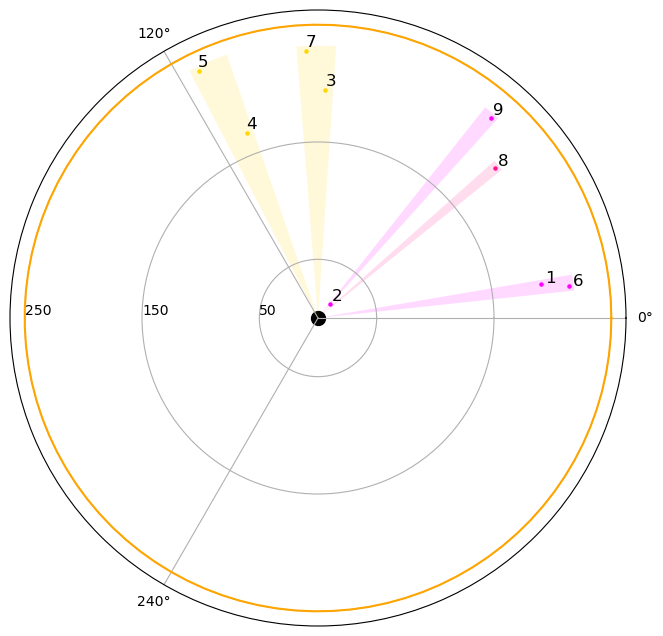

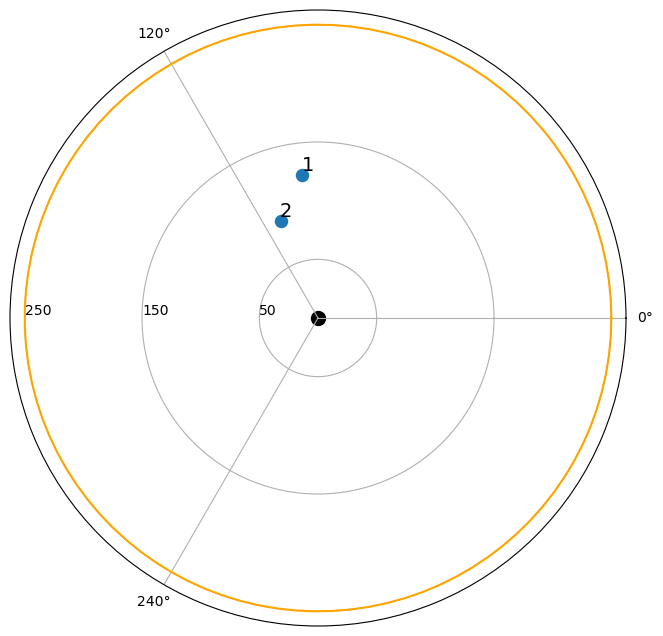

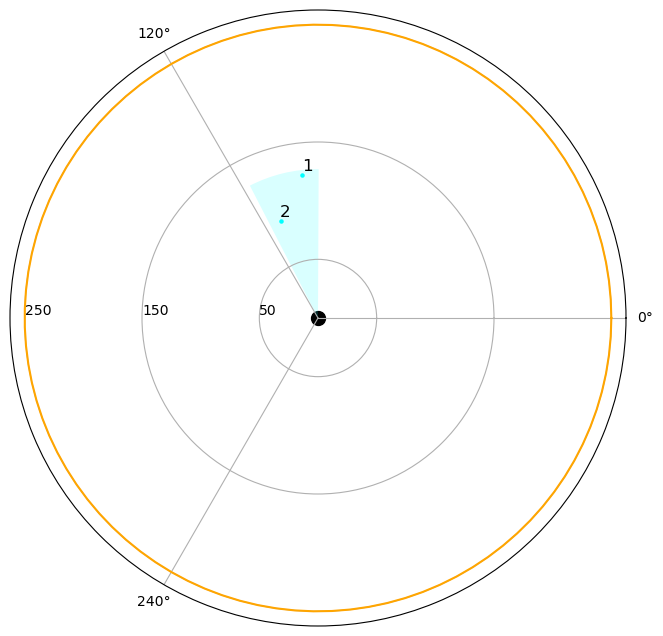

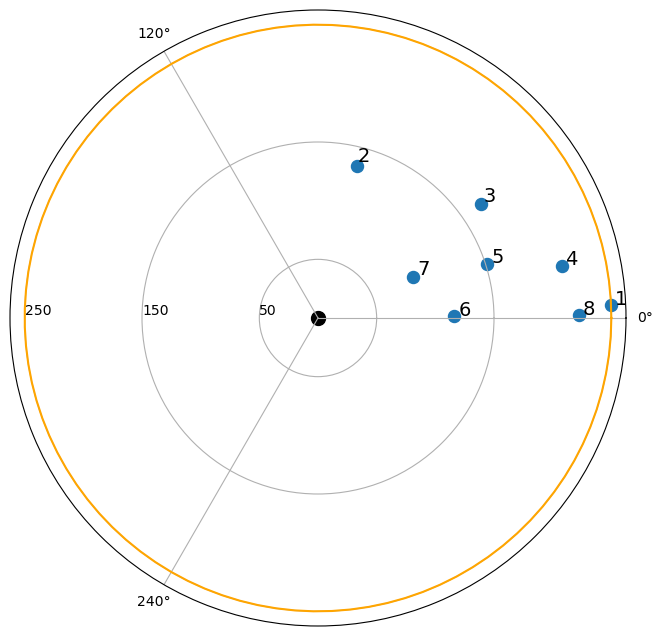

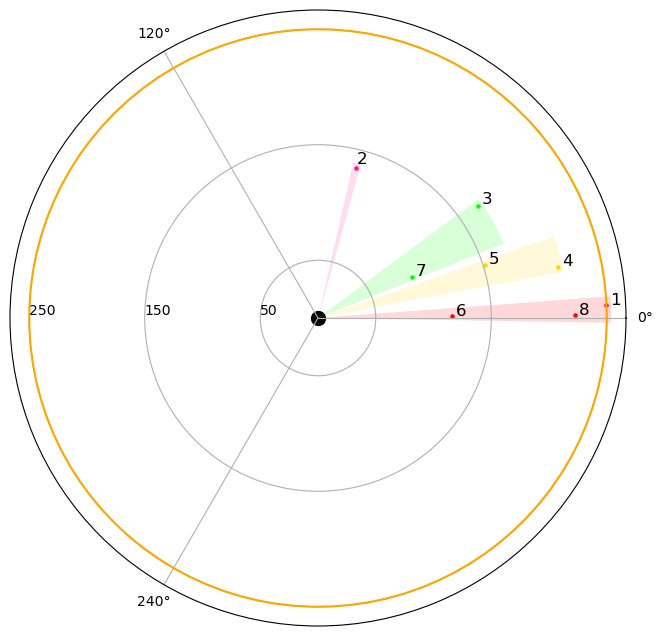

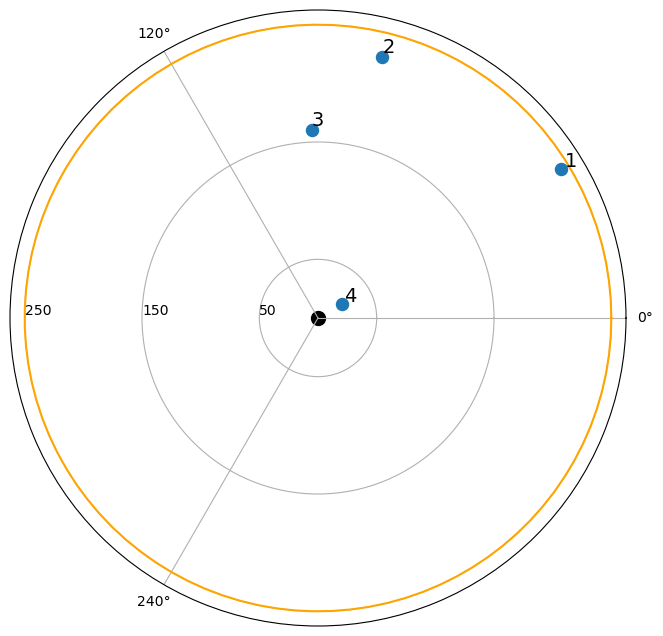

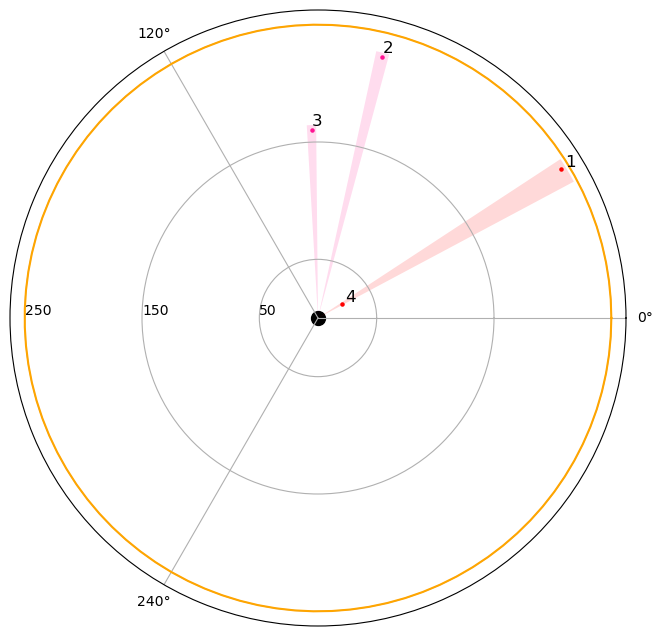

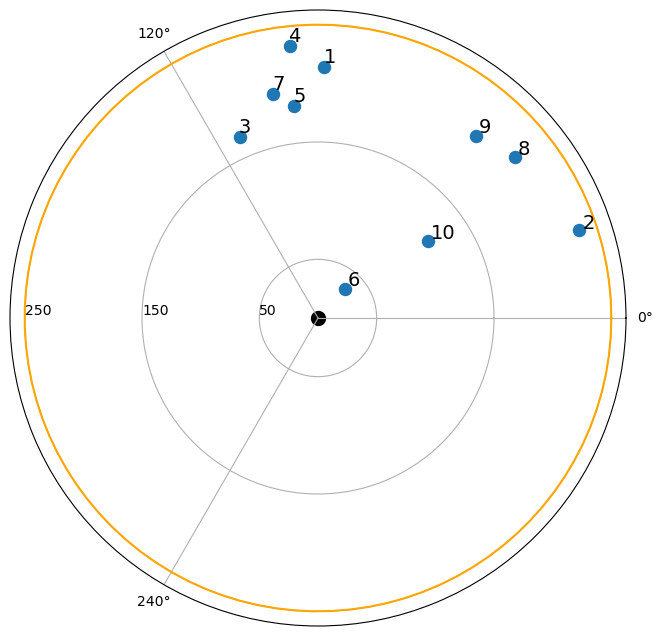

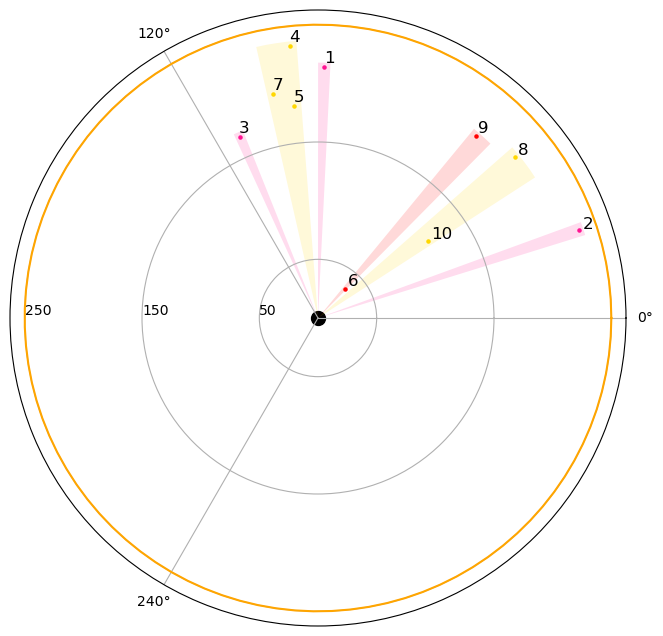

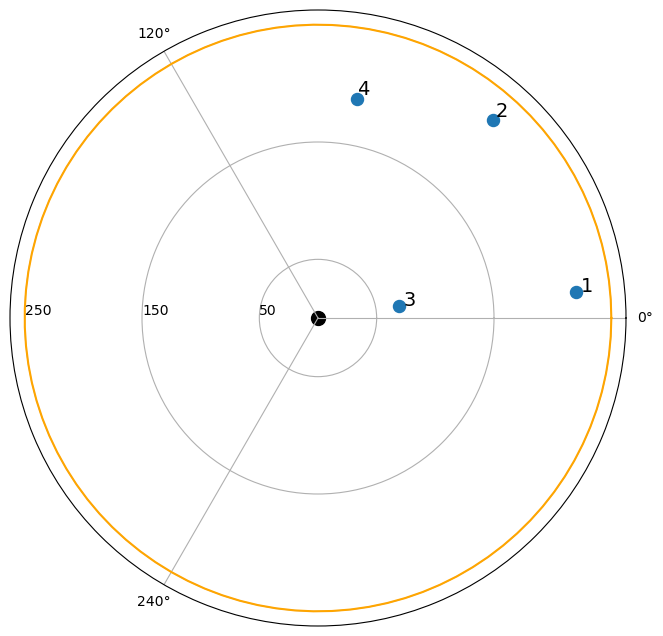

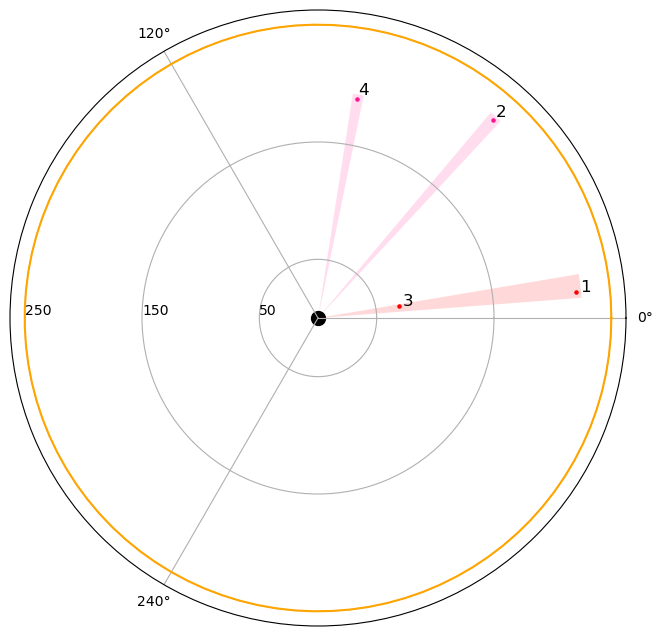

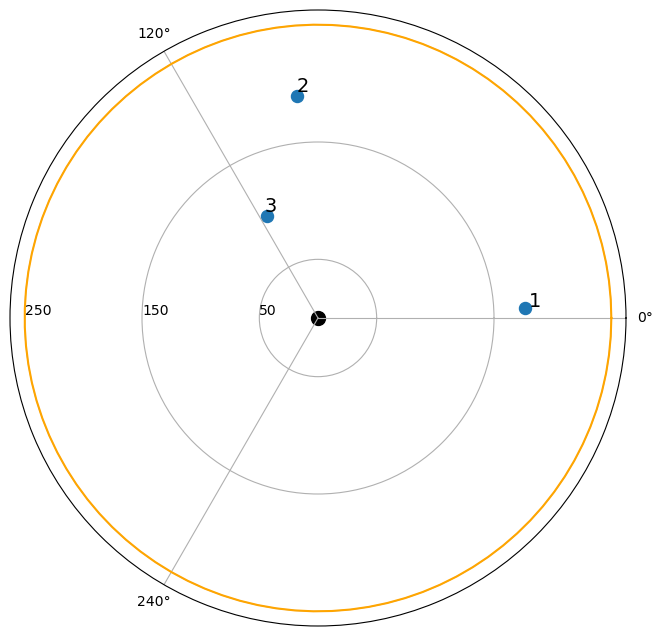

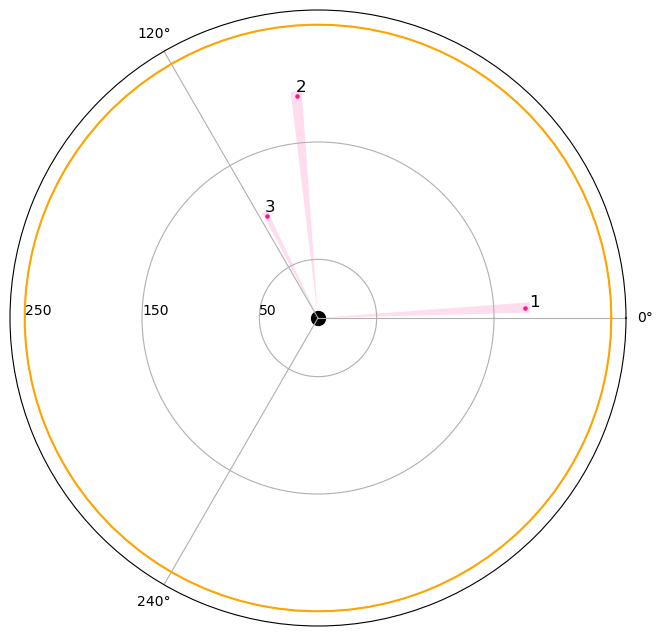

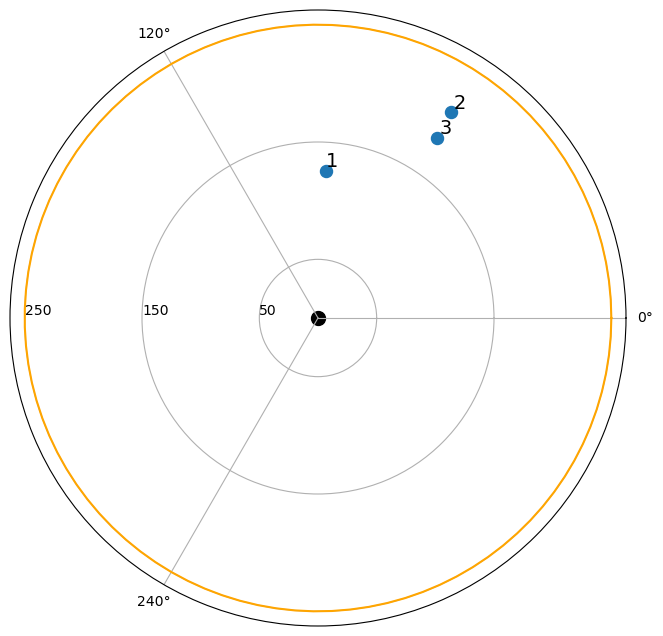

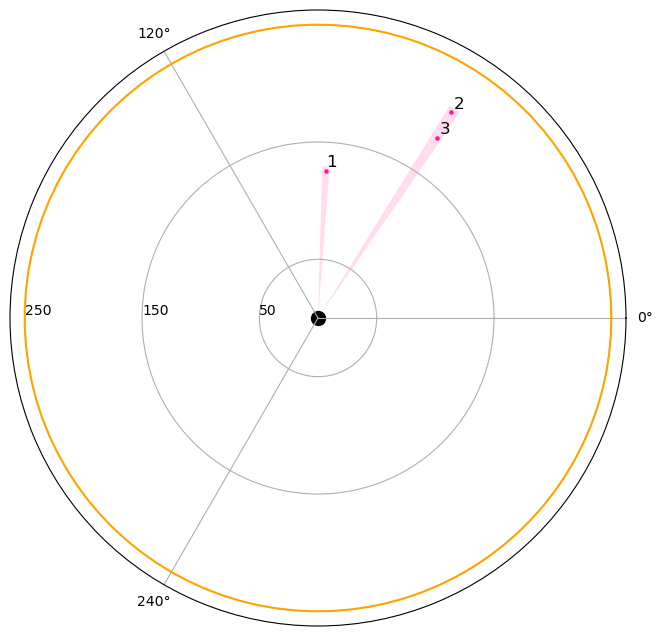

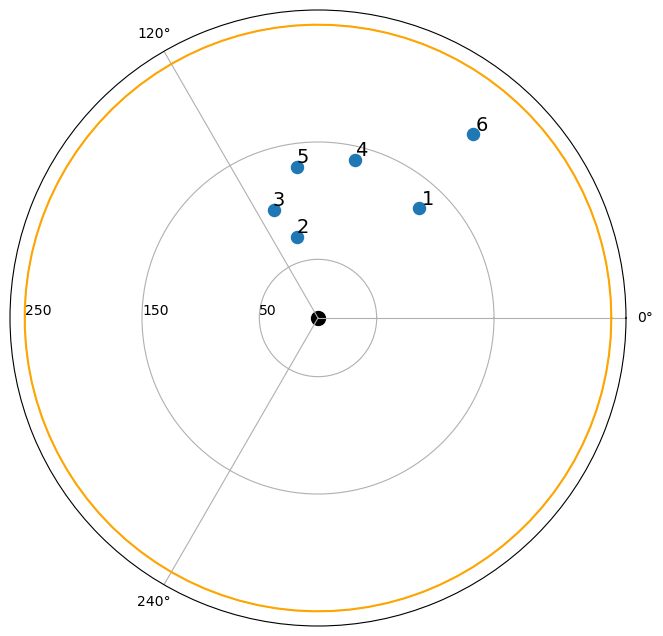

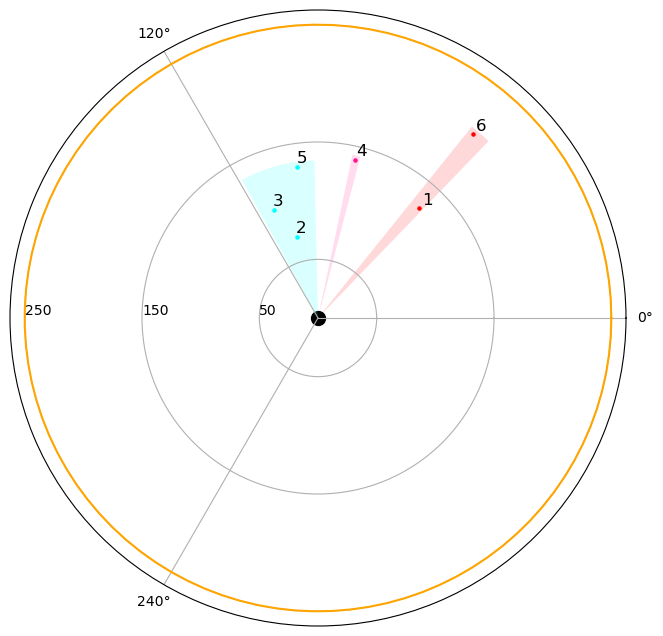

In [265]:
for _ in range(10):
    K = np.random.randint(2,11)
    params = {
        'K':K,
        'L_beams':5,
        'R':250,
        'theta': 2*np.pi/3
    }
    
    test = multicastBeamForming(params)
    test.generate_UEs()
    test.elligible_groups()
    res, _, _ = test.BinPackProblem_algorithm()
    test.plot_UEs()
    test.plot_Answer(res)